In [1]:
# Boosted Decision Tree Test File for AN-19-154 Work

# Coders: Nathan Suri, Caltech
# Date: September 24, 2019
# LPC LLP Group

# Description
# Study shower shape to improve signal/bkg discrimination

# Action Plan
# Begin developing simple BDT

# Notes/Conclusions
# @nasurijr: 

In [3]:
# User specifics
# Setups pwd location for data files and imports of special ROOT utilities

work_location = input("Username: ")
if work_location == 'nasurijr':
#     pwd = '/nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/'
    pwd = '/storage/user/nasurijr/gpu/nasurijr/LLP_analysis/delayed_jet_analyzer/'
    
    # Sets display width
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:85% !important; }</style>"))
else:
    print("Unrecognized username")
    
# elif work_location == '<Insert Tier2 username here>':
#     pwd = '/home/cms/delayed_jet_analyzer/'

Username:  nasurijr


# Imports

In [4]:
# Imports

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import math
import pickle as pickle
import ROOT as root
import os
import shlex
import uproot
import seaborn as sns

root.gROOT.SetBatch(True)
root.gStyle.SetOptStat(0)
root.gStyle.SetOptFit(111)
root.gStyle.SetPaintTextFormat("2.1f")

plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

test_name = 'xgb_wH_vs_WJetsToLNu_cscBDT'

lumi_sf_sig = 1.0 # scale lumi from sample to full run2
lumi_sf_bkg = 1.0

plotDir = pwd + 'plot_scripts/LLP_muon_system_studies/Test_scripts/'
dataDir = pwd + 'data/'

os.system("mkdir -p "+ plotDir)
os.system("mkdir -p "+ plotDir + "training")
os.system("mkdir -p "+ plotDir + "results")
os.system("mkdir -p "+ plotDir + "scores")
os.system("mkdir -p "+ plotDir + "variables")

Welcome to JupyROOT 6.18/02


0

# Load/Read Signal and Background Datafiles

In [5]:
#signal

# Normalized sample with no genLLP information stored
# signalFileName =  dataDir + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'

# WplusH sample with genLLP information stored
signalFileName = dataDir + 'WplusH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_Job0_Of_0.root'
signalFile = root.TFile(signalFileName)
signalTree = signalFile.Get('t')
signalHisto = root.gDirectory.Get('NEvents')
signalEvents = lumi_sf_sig*signalHisto.Integral()

#bkg
bkgFileName    = dataDir + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root'
bkgFile = root.TFile(bkgFileName)
bkgTree = bkgFile.Get('t')
bkgHisto = root.gDirectory.Get('NEvents')
bkgEvents = lumi_sf_bkg*bkgHisto.Integral()

print('[INFO]: S =' + str(signalEvents) + '; B =' + str(bkgEvents) +"; S/sqrt(B) = " + str(signalEvents/math.sqrt(bkgEvents)))

[INFO]: S =24994.0; B =256558720.0; S/sqrt(B) = 1.560423116358426


# Variable Definitions

## *Set of Variables excluding Matched Reco Object (Muon/Jet) Pt*

In [6]:
# Old refers to variable set exclusing matched reco objects (objects used in vetoes i.e. muons/jets)
# Old variable set removes redundant variables

variables_old = [['cscClusterXSpread', 'cscClusterXSpread', '$\Delta x_{cluster}$', 100, 0, 120],
             ['cscClusterYSpread', 'cscClusterYSpread', '$\Delta y_{cluster}$', 100, 0, 120],
             ['cscClusterZSpread', 'cscClusterZSpread', '$\Delta z_{cluster}$', 100, 0, 120],
             ['cscClusterTimeSpread', 'cscClusterTimeSpread', '$\Delta t_{cluster}$', 150, -100, 100],
#              ['cscClusterEtaSpread', 'cscClusterEtaSpread', '$\Delta \eta_{cluster}$', 100, -4, 4],
#              ['cscClusterPhiSpread', 'cscClusterPhiSpread', '$\Delta \phi_{cluster}$', 100, -4, 4],
#              ['cscClusterVertexN', 'cscClusterVertexN', '$N_{vertex_groups}$', 100, 0, 120],
#             ['cscClusterEta', 'cscClusterEta', '$\eta_{cluster}$', 100, -4, -4],
#             ['cscClusterPhi', 'cscClusterPhi', '$\phi_{cluster}$', 100, -4, -4],
            ['cscClusterEtaPhiSpread', 'cscClusterEtaPhiSpread', '$\Delta \eta\times\phi_{cluster}$', 100, -4, -4],
            ['cscClusterX', 'cscClusterX', '$x_{cluster}$', 150, -1100, 1100],
            ['cscClusterY', 'cscClusterY', '$y_{cluster}$', 150, -1100, 1100],
            ['cscClusterZ', 'cscClusterZ', '$z_{cluster}$', 150, -1100, 1100]]

## *Set of Variables including Matched Reco Object (Muon/Jet) Pt*

In [7]:
# Standard variable set removes redundant variables

variables = [['cscClusterXSpread', 'cscClusterXSpread', '$\Delta x_{cluster}$', 100, 0, 120],
             ['cscClusterYSpread', 'cscClusterYSpread', '$\Delta y_{cluster}$', 100, 0, 120],
             ['cscClusterZSpread', 'cscClusterZSpread', '$\Delta z_{cluster}$', 100, 0, 120],
             ['cscClusterTimeSpread', 'cscClusterTimeSpread', '$\Delta t_{cluster}$', 150, -100, 100],
#              ['cscClusterEtaSpread', 'cscClusterEtaSpread', '$\Delta \eta_{cluster}$', 100, -4, 4],
#              ['cscClusterPhiSpread', 'cscClusterPhiSpread', '$\Delta \phi_{cluster}$', 100, -4, 4],
#              ['cscClusterVertexN', 'cscClusterVertexN', '$N_{vertex_groups}$', 100, 0, 120],
#             ['cscClusterEta', 'cscClusterEta', '$\eta_{cluster}$', 100, -4, -4],
#             ['cscClusterPhi', 'cscClusterPhi', '$\phi_{cluster}$', 100, -4, -4],
            ['cscClusterEtaPhiSpread', 'cscClusterEtaPhiSpread', '$\Delta \eta\times\phi_{cluster}$', 100, -4, -4],
            ['cscClusterX', 'cscClusterX', '$x_{cluster}$', 150, -1100, 1100],
            ['cscClusterY', 'cscClusterY', '$y_{cluster}$', 150, -1100, 1100],
            ['cscClusterZ', 'cscClusterZ', '$z_{cluster}$', 150, -1100, 1100],
            ['cscClusterJetVetoPt', 'cscClusterJetVetoPt', '$p_{T, jet}$', 100, 0, 200],
            ['cscClusterMuonVetoPt', 'cscClusterMuonVetoPt', '$p_{T, muon}$', 150, 0, 200],
            ]
cluster_counts = [['nCscClusters', 'nCscClusters', '$N_{clusters}$', 5, 0, 5]]
llp_matching = [['cscCluster_match_gLLP', 'cscCluster_match_gLLP', 'llp_matching']]
llp_csc = [['gLLP_csc', 'gLLP_csc', 'llp_csc']]
cluster_size = [['cscClusterSize', 'cscClusterSize', '$N_{segments}', 150, 0, 250]]
cluster_time = [['cscClusterTime', 'cscClusterTime', 'ns', 150, -50, 50]]
jet_veto = [['cscClusterJetVetoPt', 'cscClusterJetVeto', '$p_{T, jet}$', 100, 0, 200]]
muon_veto = [['cscClusterMuonVetoPt', 'cscClusterMuonVeto', '$p_{T, muon}$', 150, 0, 200]]
ncsc = [['nCsc', 'nCsc', '$N_{CSC}$', 150, 0, 250]]

In [8]:
## Needs before switching to nCscRechits:
# Recheck OOT counts
# Instead of pre-training cut, apply vetoes post-basic training
# Create correlation matrix of all training variables

In [9]:
# Extracts the number of clusters per event for both signal and background

count_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_counts], flatten=False)
count_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_counts], flatten=False)

In [10]:
# Extracts the size of clusters per event for both signal and background

size_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_size], flatten=True)
size_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_size], flatten=True)

In [11]:
stack_arr_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in jet_veto], flatten=False)
stack_arr_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in jet_veto], flatten=False)

In [12]:
# Extracts the CSC time of clusters (filtered to only events with one cluster*)

time_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_time], flatten=True)#.loc[count_signal['nCscClusters']==1]
time_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in cluster_time], flatten=True)#.loc[count_bkg['nCscClusters']==1]

In [13]:
# Extracts the nCsc segments (filtered to only events with one cluster*)

ncsc_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=False)#.loc[count_signal['nCscClusters']==1]
ncsc_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=False)#.loc[count_bkg['nCscClusters']==1]

# Extracts segments after pre-training veto cut
# ncsc_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=True).loc[count_signal['nCscClusters']==1]#.loc[jetVeto_signal['cscClusterJetVeto'] == 0]
# ncsc_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in ncsc], flatten=True).loc[count_bkg['nCscClusters']==1]#.loc[jetVeto_bkg['cscClusterJetVeto'] == 0]

In [14]:
# ncsc_signal_flat = []
# ncsc_bkg_flat = []

# for x in range(len(stack_arr_signal.to_numpy())):
#     print(ncsc_signal['nCsc'])

In [15]:
# Extracts the pt of matched reco jets/muons (Currently flattened*)

jetVeto_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in jet_veto], flatten=True)
jetVeto_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in jet_veto], flatten=True)
muonVeto_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in muon_veto], flatten=True)
muonVeto_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in muon_veto], flatten=True)

## *Training Variable Sets*

In [16]:
# No training on vetoes

old_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables_old], flatten=True)#.loc[count_signal['nCscClusters']==1]
old_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables_old], flatten=True)#.loc[count_bkg['nCscClusters']==1]

In [19]:
print(old_signal.shape)
print(old_bkg.shape)

(1622, 8)
(1921607, 8)


In [17]:
# Train on veto variables

df_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)#.loc[count_signal['nCscClusters']==1]
df_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)#.loc[count_bkg['nCscClusters']==1]
# df_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)#.loc[muonVeto_signal['cscClusterMuonVeto'] == 0]
# df_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=True)#.loc[muonVeto_bkg['cscClusterMuonVeto'] == 0]

In [17]:
# Extracts cluster timings to define Boolean regions to differentiate between IT and OOT

in_time_signal = []
out_time_bkg = []
in_time_bkg = []
for x in range(len(time_signal['cscClusterTime'])):
    try:
        x_0 = time_signal['cscClusterTime'][x][0]
    except IndexError:
        continue
    if x_0 < 22 or x_0 > -12.5:
        in_time_signal.append(x)
        
for y in range(len(time_bkg['cscClusterTime'])):
    try:
        y_0 = time_bkg['cscClusterTime'][y][0]
    except IndexError:
        continue
    if y_0 < 22 or y_0 > -12.5:
        in_time_bkg.append(y)
    else:
        out_time_bkg.append(y)
        
in_time_signal_df = pd.DataFrame(in_time_signal, columns =['Bool'])
in_time_bkg_df = pd.DataFrame(in_time_bkg, columns =['Bool'])

In [18]:
print(np.count_nonzero(in_time_bkg_df))
print(len(in_time_signal_df)/len(df_bkg))

1896256
0.0007644643259521848


In [19]:
# Train on only in-time clusters with veto variables

in_signal = df_signal.loc[in_time_signal_df['Bool']]
in_bkg = df_bkg.loc[in_time_bkg_df['Bool']]

KeyboardInterrupt: 

In [20]:
# Extracts Boolean array matching clusters to LLP

cluster_matching = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in llp_matching], flatten=True)
gen_matching_np = np.ravel(cluster_matching.to_numpy()*1)

# in_gen_matching_np = np.ravel(uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in llp_matching], flatten=True).loc[in_time_signal_df['Bool']]*1)

In [21]:
# Identifies which LLP (if any) decays in the CSC

llp_decay_csc = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in llp_csc], flatten=False)

In [22]:
# # Defines BDTs with pre-training veto cuts (jet/muon pT respectively)

# noveto_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=False).loc[count_signal['nCscClusters']==1]
muon_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables_old], flatten=True).loc[muonVeto_signal['cscClusterMuonVetoPt'] < 20]
muon_gen_matching = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in llp_matching], flatten=True).loc[muonVeto_signal['cscClusterMuonVetoPt'] < 20]
muon_gen_matching_np = np.ravel(muon_gen_matching.to_numpy()*1)

jet_signal = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in variables_old], flatten=True).loc[jetVeto_signal['cscClusterJetVetoPt'] < 10]
jet_gen_matching = uproot.open(signalFileName)['MuonSystem'].pandas.df([row[0] for row in llp_matching], flatten=True).loc[jetVeto_signal['cscClusterJetVetoPt'] < 10]
jet_gen_matching_np = np.ravel(jet_gen_matching.to_numpy()*1)

both_signal = muon_signal.loc[jetVeto_signal['cscClusterJetVetoPt'] < 10]
both_gen_matching = muon_gen_matching.loc[jetVeto_signal['cscClusterJetVetoPt'] < 10]
both_gen_matching_np = np.ravel(both_gen_matching.to_numpy()*1)


# noveto_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables], flatten=False).loc[count_bkg['nCscClusters']==1]
muon_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables_old], flatten=True).loc[muonVeto_bkg['cscClusterMuonVetoPt'] < 20]
jet_bkg = uproot.open(bkgFileName)['MuonSystem'].pandas.df([row[0] for row in variables_old], flatten=True).loc[jetVeto_bkg['cscClusterJetVetoPt'] < 10]
both_bkg = muon_bkg.loc[jetVeto_bkg['cscClusterJetVetoPt'] == 0]

# BDT Implementation

In [35]:
def bdt_execution(signal_df, bkg_df, signal_y, veto_setup):
    # Create concatenated numpy array
    x = np.concatenate([bkg_df.values, signal_df.values])
#     y = np.concatenate([np.zeros(len(bkg_df)), np.ones(len(signal_df))])
    y = np.concatenate([np.zeros(len(bkg_df)), signal_y])
    jet_veto = np.concatenate([jetVeto_signal.values, jetVeto_bkg.values])
    muon_veto = np.concatenate([muonVeto_signal.values, muonVeto_bkg.values])
    
    # Split data into train/test sets
    seed = 7
    test_size = 0.2
    sample_size = 1.0
    x_train, x_test, y_train, y_test, jet_train, jet_test, muon_train, muon_test = train_test_split(x, y, jet_veto, muon_veto, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)
    
    # Run XGB Classifier
    model = xgb.XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=400, verbosity=2, n_jobs=4, reg_lambda=1.0, silent=1)
    model.fit(x_train, y_train)
    
    # Make predictions for test data
    y_pred = model.predict_proba(x_test)[:, 1]
    y_pred_train = model.predict_proba(x_train)[:, 1]
    y_pred_bkg = model.predict_proba(bkg_df.values)[:, 1]
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    AUC = roc_auc_score(y_test, y_pred)
    print("AUC: "+str(AUC))
    
    # Generate ROC curve arrays
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    
    # Compute thresholds
    significance = []
    effSignal = []
    effBkg = []
    thresholds = []

    ctr = 0
    for i in range(len(fpr)):
        if fpr[i] > 1e-5 and tpr[i] > 1e-5:
    #         print("thr = "+str(thr[i])+", fpr = "+str(fpr[i]) + ", tpr = "+str(tpr[i]))
            #print fpr[i], tpr[i] 
            #significance.append(math.sqrt(lumi)*4.8742592356*0.006431528796*tpr[i]/math.sqrt(fpr[i]*0.9935684712))
            significance.append(signalEvents*tpr[i]/math.sqrt(fpr[i]*bkgEvents))
            effSignal.append(tpr[i])
            effBkg.append(fpr[i])
            thresholds.append(thr[i])
            #print significance[ctr], ' ' , fpr[ctr], ' ', tpr[ctr]
            ctr = ctr + 1
    
    # 80% signal efficiency threshold
    idx_WP80 = 0
    minD0p8 = 999.0
    for idx in range(len(effSignal)):
            if abs(effSignal[idx] - 0.80) < minD0p8:
                    idx_WP80 = idx
                    minD0p8 = abs(effSignal[idx] - 0.80)

    WP80_significance = significance[idx_WP80]
    WP80_threshold = thresholds[idx_WP80]
    WP80_effSignal = effSignal[idx_WP80]
    WP80_effBkg = effBkg[idx_WP80]

    print("WP80_significance: "+str(WP80_significance))
    print("WP80_threshold: "+str(WP80_threshold))
    print("WP80_effSignal: "+str(WP80_effSignal))
    print("WP80_effBkg: "+str(WP80_effBkg))
    
    # Plot nCsc segment distributions
    # To be added
    
    # Plot discriminator plots (grid style)
    y_frame = pd.DataFrame({'truth':y_test, 'disc':y_pred})
    y_frame_train = pd.DataFrame({'truth':y_train, 'disc':y_pred_train})
    disc_bkg    = y_frame[y_frame['truth'] == 0]['disc'].values
    disc_bkg_train    = y_frame_train[y_frame_train['truth'] == 0]['disc'].values
    disc_signal = y_frame[y_frame['truth'] == 1]['disc'].values
    disc_signal_train = y_frame_train[y_frame_train['truth'] == 1]['disc'].values
    
    # Regather discriminator arrays for plotting nCsc on whole dataset (*change to identify the train/test set*)
    disc_signal_prime = np.concatenate((disc_signal_train, disc_signal))
    disc_bkg_prime = np.concatenate((disc_bkg_train, disc_bkg))
    
    f = plt.figure(figsize=(10,8))
    ax = f.add_subplot(111)
    plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
    plt.hist(disc_signal, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WH - test")
    plt.hist(disc_signal_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WH  - train")
    plt.hist(disc_bkg, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WJetsToLNu - test")
    plt.hist(disc_bkg_train, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WJetsToLNu- train")
    plt.yscale("log")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0001, 1000.0])
    plt.legend(loc="upper center", fontsize=16)
    plt.xlabel('BDT response',horizontalalignment='right', x=1.0, fontsize=16)
    plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
#     plt.axvline(x=WP90_threshold, color="black", linestyle='--')
#     plt.axvline(x=WP80_threshold, color="black")
#     plt.text(0.84,0.9,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#     plt.text(0.84,0.8,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#     plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
#     plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
    plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
    plt.savefig(plotDir+'training/mydiscriminator_' + test_name + veto_setup + '_logY.pdf')
    plt.savefig(plotDir+'training/mydiscriminator_' + test_name + veto_setup + '_logY.png')
    plt.savefig(plotDir+'training/mydiscriminator_' + test_name + veto_setup + '_logY.eps')
    
    # Plot feature importance plots (grid style)
    model.get_booster().feature_names = [row[1] for row in variables]
    xgb.plot_importance(model, max_num_features=len(variables), xlabel="F score (weight)")
    plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + veto_setup + '.pdf', bbox_inches='tight')
    plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + veto_setup + '.png', bbox_inches='tight')
    plt.savefig(plotDir+'training/myImportances_Fscore_' + test_name + veto_setup + '.eps', bbox_inches='tight')
    os.system("chmod 755 "+plotDir+"training/*")
    
    return fpr, tpr, thr, disc_signal_prime, disc_bkg_prime, jet_test, muon_test, y_test, y_pred

Accuracy: 99.94%
AUC: 0.9744132587418824
WP80_significance: 7.8538927447820805
WP80_threshold: 0.002536158
WP80_effSignal: 0.7984790874524715
WP80_effBkg: 0.02516760626770695


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


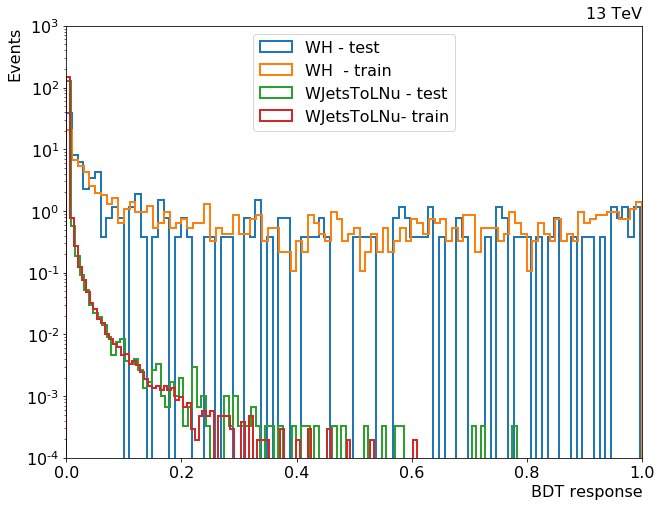

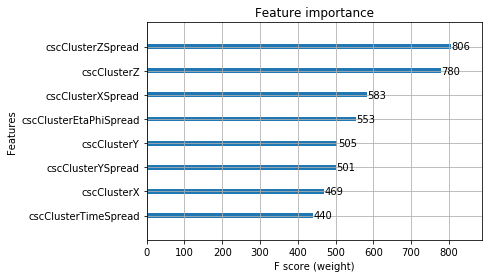

In [36]:
# BDT trained with both IT/OOT but without any matched reco object pTs

fpr_old, tpr_old, thr_old, disc_signal_old, disc_bkg_old, jet_old, muon_old, y_old, y_pred_old = bdt_execution(old_signal, old_bkg, gen_matching_np, 'old_vars')

Accuracy: 99.95%
AUC: 0.9876888376413303
WP80_significance: 12.361679757309998
WP80_threshold: 0.0050625005
WP80_effSignal: 0.7984790874524715
WP80_effBkg: 0.010159138151270997


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


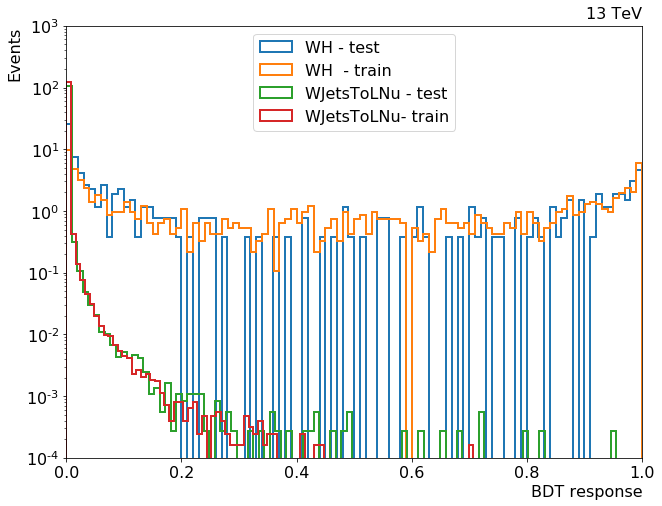

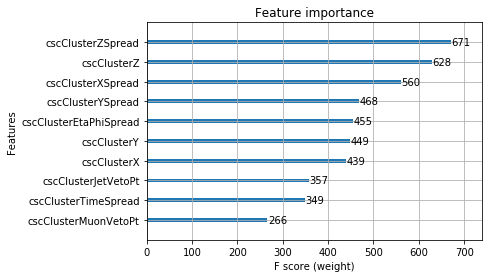

In [37]:
# BDT trained with both IT/OOT and matched reco object pTs

fpr_normal, tpr_normal, thr_normal, disc_signal_normal, disc_bkg_normal, jet_normal, muon_normal, y_normal, y_pred_normal = bdt_execution(df_signal, df_bkg, gen_matching_np, 'one_cluster')

In [ ]:
# BDT trained with only both IT (in terms of cluster timings) and matched reco object pTs

fpr_in, tpr_in, thr_in, disc_signal_in, disc_bkg_in = bdt_execution(in_signal, in_bkg, in_gen_matching_np, 'in_time')

In [ ]:
# BDT trained with both IT/OOT but filtered to only events that pass the jet veto

fpr_jet, tpr_jet, thr_jet, disc_signal_jet, disc_bkg_jet = bdt_execution(jet_signal, jet_bkg, jet_gen_matching_np, 'jet_veto')

In [ ]:
# BDT trained with both IT/OOT but filtered to only events that pass the muon veto

fpr_muon, tpr_muon, thr_muon, disc_signal_muon, disc_bkg_muon = bdt_execution(muon_signal, muon_bkg, muon_gen_matching_np, 'muon_veto')

In [ ]:
# BDT trained with both IT/OOT but filtered to only events that pass both the jet/muon vetoes

fpr_object, tpr_object, thr_object, disc_signal_object, disc_bkg_object = bdt_execution(both_signal, both_bkg, both_gen_matching_np, 'object_veto')

In [26]:
jet_veto_signal_eff = np.count_nonzero(jet_gen_matching_np)/len(old_signal)
print(jet_veto_signal_eff)
muon_veto_signal_eff = np.count_nonzero(muon_gen_matching_np)/len(old_signal)
print(muon_veto_signal_eff)
both_veto_signal_eff = np.count_nonzero(both_gen_matching_np)/len(old_signal)
print(both_veto_signal_eff)

jet_veto_bkg_eff = len(jet_bkg)/len(old_bkg)
print(jet_veto_bkg_eff)
muon_veto_bkg_eff = len(muon_bkg)/len(old_bkg)
print(muon_veto_bkg_eff)
both_veto_bkg_eff = len(both_bkg)/len(old_bkg)
print(both_veto_bkg_eff)

0.5967940813810111
0.686806411837238
0.5665844636251541
0.3011500270346642
0.34968960874934363
0.22831567536962552


In [45]:
print(len(y_pred_old))
print(len(y_old))
print(len(jet_old))
print(jet_old)
print(y_pred_old)

384646
384646
384646
[[46.8463  ]
 [37.81086 ]
 [40.84745 ]
 ...
 [ 0.      ]
 [ 5.10893 ]
 [63.209442]]
[2.1132928e-05 7.3586430e-06 7.2721142e-04 ... 1.8524523e-05 2.5137095e-05
 2.5322204e-04]


In [63]:
# jet_veto_bool = np.ravel(jet_old)<10
# muon_veto_bool = np.ravel(muon_old)<20
# object_veto_bool = jet_veto_bool*muon_veto_bool

veto_bool = {}
veto_bool['jet'] = np.ravel(jet_old)<10
veto_bool['muon'] = np.ravel(muon_old)<20
veto_bool['both'] = jet_veto_bool*muon_veto_bool

In [64]:
y_old_prime = {}
y_old_prime['jet'] = []
y_old_prime['muon'] = []
y_old_prime['both'] = []
for reco_type in ['jet', 'muon', 'both']:
    for reco_pt in range(len(veto_bool[reco_type])):
        if veto_bool[reco_type][reco_pt] == True:
            y_old_prime[reco_type].append(y_pred_old[reco_pt])
        else:
            y_old_prime[reco_type].append(0)

In [68]:
fpr_jet_post, tpr_jet_post, thr_jet_post = roc_curve(y_old, y_old_prime['jet'])
fpr_muon_post, tpr_muon_post, thr_muon_post = roc_curve(y_old, y_old_prime['muon'])
fpr_object_post, tpr_object_post, thr_object_post = roc_curve(y_old, y_old_prime['both'])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0

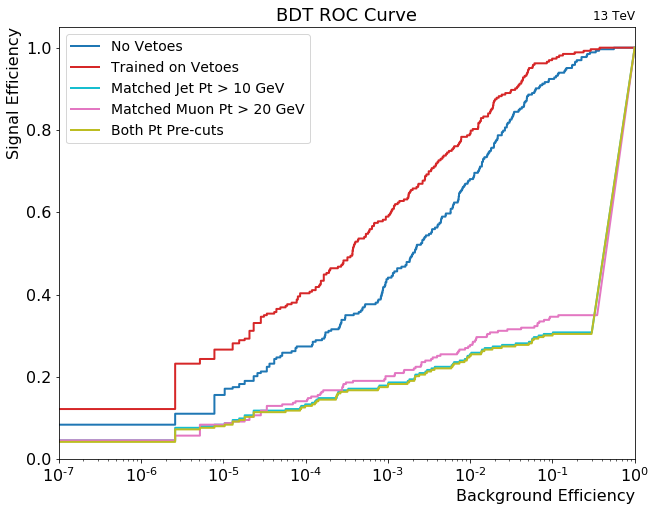

In [69]:
#plot roc curve
# fpr = Signal eff, tpr = background eff
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
ax.set_xscale('log')
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr_old, tpr_old, color='tab:blue',
         lw=lw, label='No Vetoes')
plt.plot(fpr_normal, tpr_normal, color='tab:red', 
         lw=lw, label='Trained on Vetoes')
# plt.plot(fpr_in, tpr_in, color='tab:green',
#          lw=lw, label='Trained on Vetoes: In-time')

# plt.plot(fpr_jet*jet_veto_bkg_eff, tpr_jet*jet_veto_signal_eff, color='tab:cyan',
#          lw=lw, label='Matched Jet Pt > 10 GeV')
# plt.plot(fpr_muon*muon_veto_bkg_eff, tpr_muon*muon_veto_signal_eff, color='tab:pink',
#          lw=lw, label='Matched Muon Pt > 20 GeV')
# plt.plot(fpr_object*both_veto_bkg_eff, tpr_object*both_veto_signal_eff, color='tab:olive',
#          lw=lw, label='Both Pt Pre-cuts')

plt.plot(fpr_jet_post, tpr_jet_post, color='tab:cyan',
         lw=lw, label='Matched Jet Pt > 10 GeV')
plt.plot(fpr_muon_post, tpr_muon_post, color='tab:pink',
         lw=lw, label='Matched Muon Pt > 20 GeV')
plt.plot(fpr_object_post, tpr_object_post, color='tab:olive',
         lw=lw, label='Both Pt Pre-cuts')

# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
plt.xlim([10**-7, 10**0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=16)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.axhline(y=0.9, color="black", linestyle='--')
# plt.axhline(y=0.8, color="black")
# plt.text(10**-4.5,0.3,'WP80: bkg eff = %.4f'%WP80_effBkg, fontsize=12)
# plt.text(10**-4.5,0.2,'WP90: bkg eff = %.4f'%WP90_effBkg, fontsize=12)
#plt.text(0.5,0.3,'WP90: S/sqrt(B) = %.2f'%WP90_significance, fontsize=12)
# plt.text(10**-4.5,0.4,'AUC = %.4f'%AUC, fontsize=12)
plt.title('BDT ROC Curve', fontsize=18)
plt.legend(loc="upper left", fontsize=14)
#plt.show()
# plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=12)
plt.savefig(plotDir+'training/myroc_' + test_name + '.pdf')
plt.savefig(plotDir+'training/myroc_' + test_name + '.png')
plt.savefig(plotDir+'training/myroc_' + test_name + '.eps')
os.system("chmod 755 "+plotDir+"training/*")

In [44]:
# ncsc_signal_old = ncsc_signal.loc[disc_signal_old > 0.0011161413]
# ncsc_bkg_old = ncsc_bkg.loc[disc_bkg_old > 0.0011161413]

# ncsc_signal_normal = ncsc_signal.loc[disc_signal_normal > 0.0011161413]
# ncsc_bkg_normal = ncsc_bkg.loc[disc_bkg_normal > 0.0011161413]

# # ncsc_signal_in = ncsc_signal.loc[disc_signal_in > 0.0007614495]
# # ncsc_bkg_in = ncsc_bkg.loc[disc_bkg_in > 0.0007614495]

In [227]:
# Extracts nCsc signal segments for each training type

def ncsc_signalextractor(cluster_sizes, cluster_counts, discriminator, gen_matching_arr):
    cluster_counter = 0
    gen_cluster_counter = 0
    ncsc_before = []
    ncsc_after = []
    for event in cluster_counts:
        ncsc_event_before = 0
        ncsc_event_after = 0
        for cluster in range(event):
            ncsc_event_before += cluster_sizes[cluster_counter]
            if gen_matching_arr[cluster_counter] == 1:
                if discriminator[gen_cluster_counter] > 0.0050625005:
                    ncsc_event_after += cluster_sizes[cluster_counter]
                gen_cluster_counter += 1
            cluster_counter += 1
        ncsc_before.append(ncsc_event_before)
        ncsc_after.append(ncsc_event_after)
    return np.array(ncsc_before), np.array(ncsc_after)

In [228]:
# Extracts nCsc background segments for each training type

def ncsc_bkgextractor(cluster_sizes, cluster_counts, discriminator):
    cluster_counter = 0
    ncsc_before = []
    ncsc_after = []
    for event in cluster_counts:
        ncsc_event_before = 0
        ncsc_event_after = 0
        for cluster in range(event):
            ncsc_event_before += cluster_sizes[cluster_counter]
            if discriminator[cluster_counter] > 0.0050625005:
                ncsc_event_after += cluster_sizes[cluster_counter]
            cluster_counter += 1
        ncsc_before.append(ncsc_event_before)
        ncsc_after.append(ncsc_event_after)
    return np.array(ncsc_before), np.array(ncsc_after)

In [229]:
ncsc_signal_old_before, ncsc_signal_old_after = ncsc_signalextractor(size_signal['cscClusterSize'].to_numpy(), count_signal['nCscClusters'].to_numpy(), disc_signal_old, gen_matching_np)
ncsc_signal_normal_before, ncsc_signal_normal_after = ncsc_signalextractor(size_signal['cscClusterSize'].to_numpy(), count_signal['nCscClusters'].to_numpy(), disc_signal_normal, gen_matching_np)
ncsc_signal_in_before, ncsc_signal_in_after = ncsc_signalextractor(size_signal['cscClusterSize'].to_numpy(), count_signal['nCscClusters'].to_numpy(), disc_signal_in, in_gen_matching_np)

ncsc_bkg_old_before, ncsc_bkg_old_after = ncsc_bkgextractor(size_bkg['cscClusterSize'].to_numpy(), count_bkg['nCscClusters'].to_numpy(), disc_bkg_old)
ncsc_bkg_normal_before, ncsc_bkg_normal_after = ncsc_bkgextractor(size_bkg['cscClusterSize'].to_numpy(), count_bkg['nCscClusters'].to_numpy(), disc_bkg_normal)
# ncsc_bkg_in_before, ncsc_bkg_in_after = ncsc_bkgextractor(size_bkg['cscClusterSize'].to_numpy(), count_bkg['nCscClusters'].to_numpy(), disc_bkg_in)

In [230]:
print(ncsc_signal_old_before)
print(ncsc_signal_normal_before)

[ 17  12  28 ... 147 108  48]
[ 17  12  28 ... 147 108  48]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


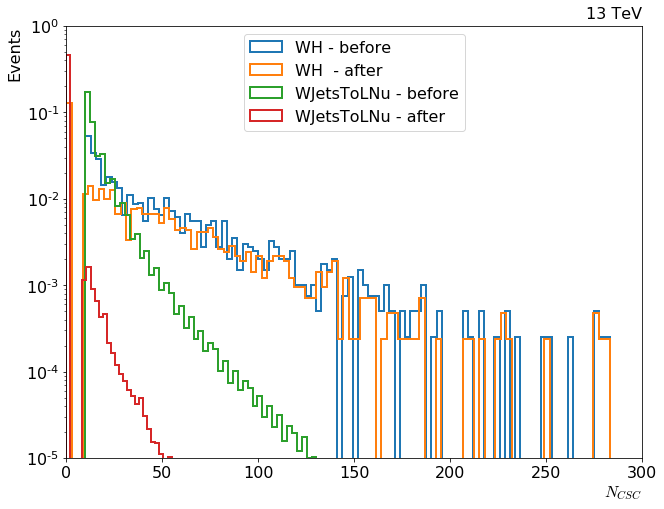

In [232]:
##########################################################
# make histogram of ncsc before and after BDT
##########################################################

f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
# plt.hist(np.array(ncsc_signal).flatten(), bins=150, alpha=1.0, histtype="step", lw=2,)
plt.hist(ncsc_signal_old_before, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WH - before")
plt.hist(ncsc_signal_old_after, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WH  - after")
plt.hist(ncsc_bkg_old_before, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WJetsToLNu - before")
plt.hist(ncsc_bkg_old_after, density=True, bins=100, alpha=1.0, histtype="step", lw=2, label="WJetsToLNu - after")
plt.yscale("log")
plt.xlim([0.0, 300])
plt.ylim([10**-5, 1])
plt.legend(loc="upper center", fontsize=16)
plt.xlabel('$N_{CSC}$',horizontalalignment='right', x=1.0, fontsize=16)
plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.axvline(x=WP90_threshold, color="black", linestyle='--')
# plt.axvline(x=WP80_threshold, color="black")
# plt.text(0.84,0.9,'WP90: disc > %.4f'%WP90_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.84,0.8,'WP80: disc > %.4f'%WP80_threshold, fontsize=12, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
# plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
# plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.pdf')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.png')
plt.savefig(plotDir+'training/mydiscriminator_' + test_name +'_logY.eps')

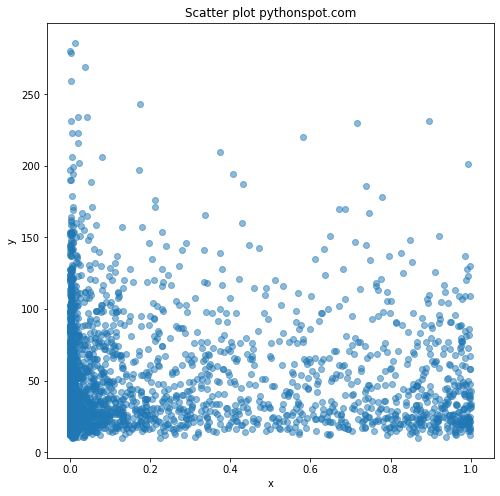

In [155]:
f_heat, ax = plt.subplots(figsize=(8, 8))

plt.scatter(np.array(disc_signal_old), np.array(ncsc_signal)[:,0], alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

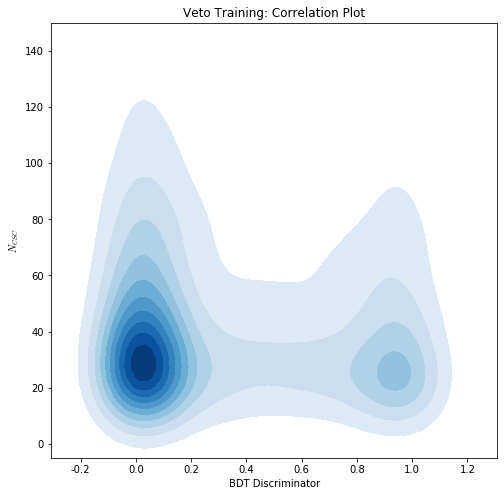

In [166]:
f_heat, ax = plt.subplots(figsize=(8, 8))

# ax = sns.kdeplot(np.array(ncsc_signal)[:,0], np.array(disc_signal_old), cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(np.array(disc_signal_normal), np.array(ncsc_signal)[:,0],
                 cmap="Blues", shade=True, shade_lowest=False)
# ax = sns.kdeplot(np.array(ncsc_bkg)[:,0], np.array(disc_bkg_normal),
#                  cmap="Reds", shade=False, shade_lowest=False)
# ax = plt.scatter(np.array(ncsc_signal)[:,0], np.array(disc_signal_old), alpha=0.5)
# ax = sns.kdeplot(np.array(ncsc_signal)[:,0], disc_signal_in,
#                  cmap="Greens", shade=True, shade_lowest=False)
plt.ylim(-5, 150)
plt.xlabel('BDT Discriminator')
plt.ylabel('$N_{CSC}$')
plt.title('Veto Training: Correlation Plot')

# Add labels to the plot0.0011161413
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
# green = sns.color_palette("Greens")[-2]
# ax.text(2.5, 8.2, "No Vetoes", size=16, color=blue)
# ax.text(3.8, 4.5, "Trained on Vetoes", size=16, color=red)
# ax.text(2.0, 7, "Trained on Vetoes: In-time", size=16, color=green)

In [170]:
os.system("chmod 755 "+plotDir+"training/*")

0

In [24]:
time_signal_spread = []
for elementS in np.array(df_signal['cscClusterTimeSpread']):
    time_signal_spread.append(elementS[0])
    
time_bkg_spread = []
for elementB in np.array(df_bkg['cscClusterTimeSpread']):
    time_bkg_spread.append(elementB[0])
    
phi_signal_spread = []
for elementS in np.array(df_signal['cscClusterPhiSpread']):
    phi_signal_spread.append(elementS[0])
    
phi_bkg_spread = []
for elementB in np.array(df_bkg['cscClusterPhiSpread']):
    phi_bkg_spread.append(elementB[0])
    
eta_signal_spread = []
for elementS in np.array(df_signal['cscClusterEtaSpread']):
    eta_signal_spread.append(elementS[0])
    
eta_bkg_spread = []
for elementB in np.array(df_bkg['cscClusterEtaSpread']):
    eta_bkg_spread.append(elementB[0])
    
nV_signal_spread = []
for elementS in np.array(df_signal['cscClusterVertexN']):
    nV_signal_spread.append(elementS[0])
    
nV_bkg_spread = []
for elementB in np.array(df_bkg['cscClusterVertexN']):
    nV_bkg_spread.append(elementB[0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


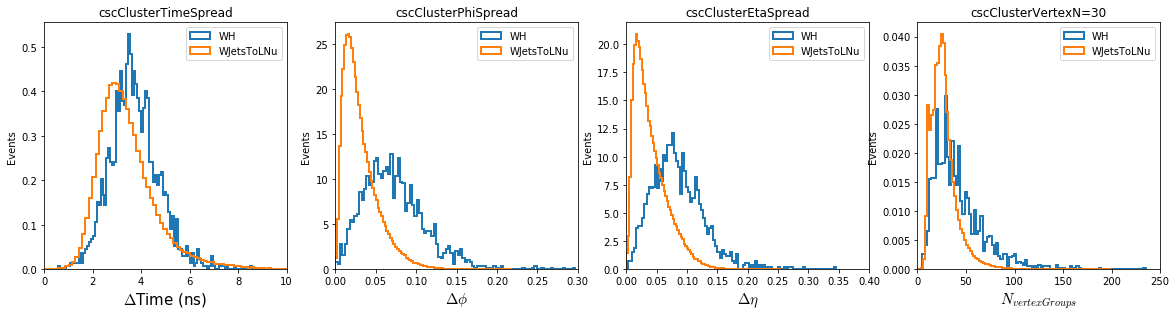

In [35]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(20, 10))
G = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(G[0, 0])
ax2 = plt.subplot(G[0, 1])
ax3 = plt.subplot(G[0, 2])
ax4 = plt.subplot(G[0, 3])

ax1.hist(time_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax1.hist(time_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax1.set_xlim(0,10)
ax1.legend(loc="upper right", fontsize = 10)
ax1.set_xlabel('$\Delta$Time (ns)', fontsize = 15)
ax1.set_ylabel('Events')
ax1.set_title('cscClusterTimeSpread')

ax2.hist(phi_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax2.hist(phi_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax2.set_xlim(0,0.3)
ax2.legend(loc="upper right", fontsize = 10)
ax2.set_xlabel('$\Delta\phi$', fontsize = 15)
ax2.set_ylabel('Events')
ax2.set_title('cscClusterPhiSpread')

ax3.hist(eta_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax3.hist(eta_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax3.set_xlim(0,0.4)
ax3.legend(loc="upper right", fontsize = 10)
ax3.set_xlabel('$\Delta\eta$', fontsize = 15)
ax3.set_ylabel('Events')
ax3.set_title('cscClusterEtaSpread')

ax4.hist(nV_signal_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WH')
ax4.hist(nV_bkg_spread, density=True, alpha=1.0, histtype="step", lw=2, bins=100, label='WJetsToLNu')
ax4.set_xlim(0,250)
ax4.legend(loc="upper right", fontsize = 10)
ax4.set_xlabel('$N_{vertexGroups}$', fontsize = 15)
ax4.set_ylabel('Events')
ax4.set_title('cscClusterVertexN=30')

plt.draw()
plt.savefig(plotDir+'variables/'+test_name + '_grid_plot'+'.pdf')#, bbox_inches='tight')
plt.savefig(plotDir+'variables/'+test_name + '_grid_plot'+'.png')#, bbox_inches='tight')
plt.savefig(plotDir+'variables/'+test_name + '_grid_plot'+'.eps')#, bbox_inches='tight')